In [ ]:
# !pip3 install ipywidgets
# !pip3 install loguru

# SICSS 2021: ML and computer vision workshop

In this notebook, we train neural networks for image classification using the CIFAR10 dataset.

We aim to cover:
* Different network architectures
* Different opimization methods
* Hyperparameter optimization
* Preventing overfitting
* Leveraging pretrained models
* Data augmentation
* Evaluating trained models
* Model introspection


Things to note:
* For simplicity in here we have no *validation* set. We use the test set directly for valiation. By doing hyperparameter optimization in this way, we are likely overfitting to the test set and so would need an independent hold-out dataset to truly test generalisation.
* The network performances are not representative of what is achieveable. Due to restricted hardware, we are running for a few epochs on a limited dataset. In reality the state-of-the-art accuracy on CIFAR10 to is ~100%.
* Try not to be overwhelmed with amount of machinery surrounding the training in this notebook. The vast majority of it can be ignored and left as is. When doing these kind of tasks yourself, there are many libraries to handle a lot of these things for you including [ignite](https://pytorch.org/ignite/index.html), [pytorch-lightning](https://www.pytorchlightning.ai/) and [fastai](https://www.fast.ai/).

# Notebook setup

## Imports

In [2]:
import collections
import itertools
import sys
from typing import Any, Dict, List, Tuple, Union

import IPython.display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.decomposition
import sklearn.manifold
import sklearn.metrics
import torch
import torchvision as tv
import tqdm.notebook
from loguru import logger

## Global constants/defaults

### Training parameters

**Very important cell** Don't worry if not all of these parameters sense yet.

In [3]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device_type} device")
DEVICE = torch.device(device_type)

# Set to < 1 to train on subset of data to speed up training
# during development (will also increase overfitting..)
TRAIN_DATA_SAMPLE_FRAC = 0.5
LOG_INTERVAL = int(500 * TRAIN_DATA_SAMPLE_FRAC)  # Batch iterations

# Hyper parameters
N_EPOCHS = 8
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
LOSS_FN = torch.nn.CrossEntropyLoss()
OPTIMIZER_TYPE = torch.optim.SGD
MOMENTUM = 0.9  # See https://distill.pub/2017/momentum/
WEIGHT_DECAY = 0  # Equivalent to L2 regularisation
AUGMENTATIONS = tv.transforms.Compose(
    [
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

Using cuda device


## Plotting / logging setup

Assign some sensible defaults plotting and logging

In [4]:
plt.style.use("seaborn-talk")
matplotlib.rcParams.update({"axes.grid": True, "grid.alpha": 0.3})

LOG_FORMAT = (
    "<fg #01665E>{time:YYYY-MM-DD HH:mm:ss.SSS}</> | "
    "<level>{level}</level> | "
    "<level><n>{message}</n></level>"
)
logger.remove()
logger.add(
    sink=sys.stdout,
    format=LOG_FORMAT,
    colorize=True,
    backtrace=True,
    level="INFO",
    diagnose=True,
)

1

## Utility functions

### Logging

In [5]:
def pad_msg(message: str) -> str:
    """Pad message to constant width with '=' symbol."""
    message_with_spaces = f" {message} "
    return f"{message_with_spaces:=^100}"


def generate_train_log_message(
    batch_num: int, batches_per_epoch: int, metrics: Dict[str, float]
) -> str:
    return (
        f"<b>Training</b>: "
        f"Batch {batch_num:04d}/{batches_per_epoch:04d} "
        f"({batch_num / batches_per_epoch * 100:03.0f}%) | "
        f"{generate_metrics_log_message(metrics)}"
    )


def generate_test_log_message(metrics: Dict[str, float]) -> str:
    return (
        f"<b>Testing</b>: {'-' * 23} | "
        f"<b>{generate_metrics_log_message(metrics)}</b>"
    )


def generate_metrics_log_message(metrics: Dict[str, float]) -> str:
    colour_cycle = itertools.cycle(["light-blue", "light-green"])
    metrics_info = []
    for (metric_name, metric), colour in zip(metrics.items(), colour_cycle):
        metric_name_pretty = _METRIC_FORMAT[metric_name]["pretty_name"]
        formatted_value = _METRIC_FORMAT[metric_name]["fmt"].format(metric)
        metrics_info.append(
            f"<{colour}>{metric_name_pretty}: " f"{formatted_value}</{colour}>"
        )
    metrics_log_message = " | ".join(metrics_info)
    return metrics_log_message


_METRIC_FORMAT = {
    "top1accuracy": {"pretty_name": "Top-1 Accuracy", "fmt": "{:04.1f}%"},
    "top3accuracy": {"pretty_name": "Top-3 Accuracy", "fmt": "{:04.1f}%"},
    "loss": {"pretty_name": "Average Loss", "fmt": "{:.4f}"},
}

### Data

In [6]:
def sample_dataset(
    dataset: torch.utils.data.Dataset, frac: float
) -> torch.utils.data.Subset:
    """
    Return a random subset of a dataset.
    
    Stratified sampling is used so the 10 classes are equally 
    represented in the sample.
    
    Args:
        dataset: The pytorch dataset to sample from.
        frac: A number between 0 and 1 specifying the size of the sample 
            as a fraction of the original dataset size.
    """
    assert 0 < frac <= 1
    sample_indices = []
    class_indices = collections.defaultdict(list)
    for idx, label in enumerate(dataset.targets):
        class_indices[label].append(idx)
    class_indices = {label: indices for label, indices in sorted(class_indices.items())}

    for _, indices in class_indices.items():
        class_sample_size = int(frac * len(indices))
        class_sample_indices = np.random.choice(indices, class_sample_size)
        sample_indices.extend(class_sample_indices)
    np.random.shuffle(sample_indices)
    return torch.utils.data.Subset(dataset, sample_indices)


def get_cifar10_dataloader(
    is_train: bool,
    augmentations: tv.transforms.Compose,
    batch_size: int,
    data_sample_frac: float = 1,
) -> torch.utils.data.DataLoader:
    """Return CIFAR10 dataloader with convenient defaults."""
    dataset = tv.datasets.CIFAR10(
        root="data",
        train=is_train,
        download=True,
        transform=augmentations,
    )

    if data_sample_frac < 1:
        assert 0 < data_sample_frac < 1
        dataset = sample_dataset(dataset, data_sample_frac)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )

### Metrics

In [7]:
def calculate_metrics(output: Dict[str, List[float]]) -> Dict[str, float]:
    """Calculate classification metrics from standard output."""
    metrics = {}
    metrics["top1accuracy"] = (
        sklearn.metrics.top_k_accuracy_score(output["y"], output["y_pred"], k=1) * 100
    )
    metrics["top3accuracy"] = (
        sklearn.metrics.top_k_accuracy_score(output["y"], output["y_pred"], k=3) * 100
    )
    metrics["loss"] = np.mean(output["loss"]) / BATCH_SIZE
    return metrics


def accumulate_dict(
    accumulator: Dict[str, List[float]],
    update: Dict[str, Union[torch.Tensor, List[float], float]],
) -> None:
    """Update each list in an accumulator dict with values from update."""
    for key, value in update.items():
        try:
            value_length = len(value)
        except TypeError:  # is scalar or 0-d tensor e.g loss
            if isinstance(value, torch.Tensor):
                value = value.item()
            accumulator[key].append(value)
        else:  # Is list or torch tensor
            if isinstance(value, torch.Tensor):
                value = value.tolist()
            accumulator[key].extend(value)

### Plotting

In [8]:
def plot_training_metrics(metrics: Dict[str, List[float]]) -> plt.Figure:
    PLOT_KWARGS = {"alpha": 0.7, "linewidth": 2, "marker": "o"}

    fig, (loss_ax, acc_ax) = plt.subplots(
        nrows=2, sharex=True, figsize=(12, 10), constrained_layout=True
    )
    for subset in ("train", "test"):
        loss_ax.plot(
            metrics[subset]["iteration"],
            metrics[subset]["loss"],
            label=subset,
            **PLOT_KWARGS,
        )
    loss_ax.set_ylabel("Average loss")
    loss_ax.legend()

    for subset in ("train", "test"):
        acc_ax.plot(
            metrics[subset]["iteration"],
            metrics[subset]["top1accuracy"],
            label=subset,
            **PLOT_KWARGS,
        )

    acc_ax.set_ylabel("Accuracy")
    acc_ax.set_xlabel("Batches")
    return fig

def display_prediction_images(df: pd.DataFrame) -> plt.Figure:
    fig, (img_axes, score_axes) = plt.subplots(
        nrows=2,
        ncols=len(df),
        figsize=(1.7 * len(df), 4),
        gridspec_kw={"wspace": 0.1, "height_ratios": [1, 1.2], "hspace": 0.2},
        sharey="row",
    )
    for img_ax, score_ax, (index, row) in zip(img_axes.flat, score_axes.flat, df.iterrows()):
        image = test_data[index][0].numpy().transpose(1, 2, 0) / 2 + 0.5
        scores = row.loc["score0":"score9"].values
        is_correct = np.argmax(scores) == row.label
        symbol = "✔" if is_correct else "✘"
        # Add image to plot
        img_ax.imshow(image)
        img_ax.text(
            0.5,
            1.05,
            f"{CLASSES[row.label.astype(int)]} {symbol}",
            transform=img_ax.transAxes,
            horizontalalignment="center",
            size=14,
        )
        img_ax.text(
            0.5,
            -0.15,
            index,
            transform=img_ax.transAxes,
            horizontalalignment="center",
            size=14,
        )
        img_ax.axis("off")
        # Add score distribution to plot
        score_ax.barh(CLASSES, scores)
        score_ax.set_xlim(0, 1)
        score_ax.get_xaxis().set_visible(False)
        for border in ("top", "right", "bottom"):
            score_ax.spines[border].set_visible(False)
        score_ax.grid(False)
    return fig


def show_svg(filepath: str) -> None:
    IPython.display.display(IPython.display.SVG(filepath))

# Data

PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html) : 
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``. 

* A ``Dataset`` stores the samples (in this case images) and their corresponding labels. It can also optionally perform an augmentation operation to each sample/label upon loading. 
* A``DataLoader`` wraps an iterable around the ``Dataset`` and handles the batching and, optionally, sampling of the dataset.




PyTorch offers domain-specific libraries such as [TorchText][],
[TorchVision][], and [TorchAudio][], all of which include datasets. For
this tutorial, we will be using a TorchVision dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list here][]). In this
tutorial, we use the CIFAR10 dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.

  [TorchText]: https://pytorch.org/text/stable/index.html
  [TorchVision]: https://pytorch.org/vision/stable/index.html
  [TorchAudio]: https://pytorch.org/audio/stable/index.html
  [full list here]: https://pytorch.org/docs/stable/torchvision/datasets.html

In [9]:
# Download training data from open datasets.
print(pad_msg("Training data"))
training_data = tv.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=AUGMENTATIONS,
)
print(training_data)


# Download test data from open datasets.
print(pad_msg("Test data"))
test_data = tv.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=AUGMENTATIONS,
)
print(test_data)

CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

========================================== Training data ===========================================
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
============================================ Test data =============================================
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here the batch size is defined above, i.e. each element 
in the dataloader iterable will return a batch of `BATCH_SIZE` images and labels.

In [10]:
train_dataloader = get_cifar10_dataloader(
    is_train=True, 
    augmentations=AUGMENTATIONS, 
    batch_size=BATCH_SIZE, 
    data_sample_frac=TRAIN_DATA_SAMPLE_FRAC
)
test_dataloader = get_cifar10_dataloader(
    is_train=False, 
    augmentations=AUGMENTATIONS, 
    batch_size=BATCH_SIZE,
)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
for images, y in test_dataloader:
    print("Shape of image batch [B, C, H, W]: ", images.shape)
    print("Shape of y (labels) batch: ", y.shape, y.dtype)
    break

Shape of image batch [B, C, H, W]:  torch.Size([16, 3, 32, 32])
Shape of y (labels) batch:  torch.Size([16]) torch.int64


   horse    horse     frog      car    horse    truck     deer    truck
   plane      dog      cat    horse      car     bird    plane      cat


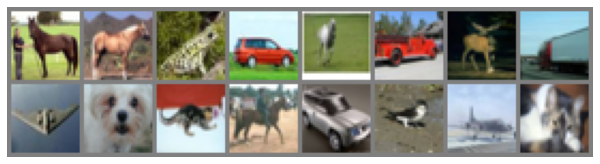

In [12]:
images, labels = next(iter(train_dataloader))
fig, ax = plt.subplots(figsize=(10.5, 5))
grid = tv.utils.make_grid(images)
grid = grid / 2 + 0.5  # undo normalisation
ax.imshow(np.transpose(grid, (1, 2, 0)))
ax.axis("off")
print(" ".join("%8s" % CLASSES[labels[j]] for j in range(BATCH_SIZE // 2)))
print(" ".join("%8s" % CLASSES[labels[j]] for j in range(BATCH_SIZE // 2, BATCH_SIZE)))

Read more about loading data in PyTorch: https://pytorch.org/tutorials/beginner/basics/data_tutorial.htm

--------------




# Training a deep learning model

## Optimizing the Model Parameters

To train a model, we need a [loss function][] and an [optimizer][].

  [loss function]: https://pytorch.org/docs/stable/nn.html#loss-functions
  [optimizer]: https://pytorch.org/docs/stable/optim.html



In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and 
backpropagates the prediction error to adjust the model's parameters. 

Training a model is an iterative process; in each iteration (or **batch**), the model makes a guess about the output, calculates the error in its guess (**loss**), collects the derivatives of the error with respect to its parameters, and optimizes these parameters using gradient descent. For a more detailed walkthrough of this process, check out [this video](https://www.youtube.com/watch?v=tIeHLnjs5U8) on backpropagation from 3Blue1Brown.

Iterating over the entire dataset once is known as an **epoch**.


## Train functions 

In [13]:
def train_step(
    images: torch.Tensor,  # shape B x C x H x W
    y: torch.tensor,  # shape B
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Dict[str, torch.Tensor]:
    """
    Logic for a single training batch iteration.

    Returns:
        A dictionary with the model predictions "y_pred", corresponding
        class labels "y", and the loss.
    """
    # First put the model in training mode
    model.train()
    
    # Then reset the optimizer gradients (calculated in any previous batches)
    optimizer.zero_grad()
    
    # Then move the images and labels to the torch device
    images, y = images.to(device), y.to(device)
    
    # Calculate predictions and compute the loss
    y_pred = model(images)
    loss = loss_fn(y_pred, y)

    # Backpropagate the loss through the network and update model parameters with optimizer
    loss.backward()
    optimizer.step()
    
    # Return a dictionary with the predictions, labels and batch loss
    return {"y_pred": y_pred, "y": y, "loss": loss}


def train_epoch(
    dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    log_interval: int,
    lr_scheduler: torch.optim.lr_scheduler._LRScheduler = None,
) -> Dict[str, Any]:
    """Train a pytorch model on the given data for a single epoch."""
    log_metrics_over_epoch = collections.defaultdict(list)
    log_outputs = collections.defaultdict(list)

    for batch_number, (images, y) in enumerate(dataloader, start=1):
        batch_outputs = train_step(images, y, model, loss_fn, optimizer, device)

        # Update optimizer learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        # Accumulate batch outputs over log interval
        accumulate_dict(log_outputs, update=batch_outputs)
        if batch_number % log_interval == 0:
            log_metrics = calculate_metrics(log_outputs)
            log_message = generate_train_log_message(
                batch_number, len(dataloader), log_metrics
            )
            if lr_scheduler is not None:
                log_message += f" | lr: {lr_scheduler.get_last_lr()[0]:.5f}"
            logger.opt(colors=True).info(log_message)

            # Accumulate log metrics for plotting
            accumulate_dict(log_metrics_over_epoch, update=log_metrics)

            # Reset log outputs to be accumulated over next log interval
            log_outputs = collections.defaultdict(list)

    return log_metrics_over_epoch

## Test functions

We also check the model's performance against the test dataset to ensure it is learning.



In [14]:
def test_step(
    images: torch.Tensor,
    y: torch.tensor,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    device: torch.device,
) -> Dict[str, torch.Tensor]:
    """
    Logic for a single test batch iteration.

    Returns:
        A dictionary with the model predictions "y_pred", corresponding class labels "y",
        and the loss.
    """
    
    # First put the model in evaluation mode
    model.eval()
    with torch.no_grad(): # Ensure gradients are not computed
        # Then move images and labels to torch device
        images, y = images.to(device), y.to(device)
        # Calculate predictions and compute the loss
        y_pred = model(images)
        loss = loss_fn(y_pred, y)

    # Return a dictionary with the predictions, labels and batch loss
    return {"y_pred": y_pred, "y": y, "loss": loss}


def test_epoch(
    dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    device: torch.device,
) -> Dict[str, float]:
    """Evaluate model performance on given dataloader."""
    epoch_outputs = collections.defaultdict(list)
    for images, y in dataloader:
        batch_outputs = test_step(images, y, model, loss_fn, device)

        # Accumulate batch outputs to calculate metrics
        accumulate_dict(epoch_outputs, batch_outputs)

    metrics = calculate_metrics(epoch_outputs)
    logger.opt(colors=True).info(generate_test_log_message(metrics))
    return metrics

## Overall training/testing function

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns 
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.

In [15]:
def train_model(
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    n_epochs: int = N_EPOCHS,
    log_interval: int = LOG_INTERVAL,
    lr_scheduler: torch.optim.lr_scheduler._LRScheduler = None,
) -> Dict[str, Dict[str, List[float]]]:
    metrics = {
        "train": collections.defaultdict(list),
        "test": collections.defaultdict(list),
    }
    # Test untrained model and accumulate metrics
    initial_test_metrics = test_epoch(test_dataloader, model, loss_fn, device)
    accumulate_dict(metrics["test"], update=initial_test_metrics)
    metrics["test"]["iteration"].append(0)

    # Train for specified number of epocchs
    for epoch_num in range(1, n_epochs + 1):
        logger.opt(colors=True).info(pad_msg(f"<b>Epoch {epoch_num} / {n_epochs}</b>"))
        # Train model for single epoch
        train_epoch_metrics = train_epoch(
            train_dataloader,
            model,
            loss_fn,
            optimizer,
            device,
            lr_scheduler=lr_scheduler,
            log_interval=log_interval,
        )
        # Test current model
        test_epoch_metrics = test_epoch(test_dataloader, model, loss_fn, device)

        # Accumulate test and train metrics for epoch
        accumulate_dict(metrics["train"], update=train_epoch_metrics)
        iteration_nums_for_train_metrics = [
            (epoch_num - 1) * len(train_dataloader) + i * log_interval
            for i in range(len(train_dataloader) // log_interval)
        ]
        metrics["train"]["iteration"].extend(iteration_nums_for_train_metrics)
        accumulate_dict(metrics["test"], update=test_epoch_metrics)
        metrics["test"]["iteration"].append(epoch_num * len(train_dataloader))

    logger.opt(colors=True).info(pad_msg(f"<b>Training completed!</b>"))
    return metrics

# A naive approach - FCNN

A naive approach may be to apply the most basic type of neural network to the problem, a so-called 'fully-connected' or 'dense' network. This approach is naive as it treats every pixel in the image as an independent 'feature', which ignores all the local-correlation information present in images. Furthermore, FCNNs tend have A LOT of parameters and are easy to overfit. 

Here we use a 3-layer network that goes from 3072 pixel values -> 256 -> 256 -> 10 classification predictions.

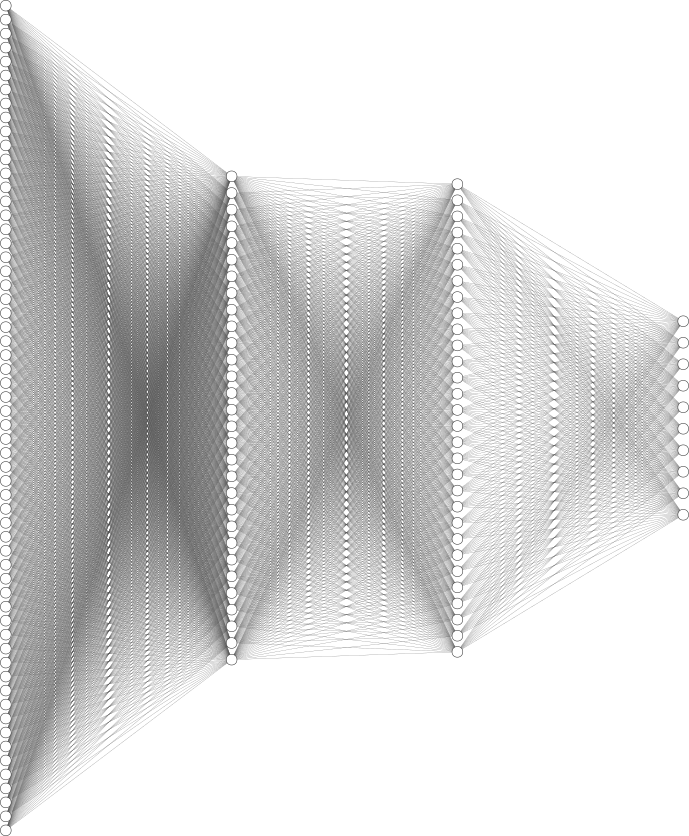

In [16]:
show_svg("figures/networks/fcnn.svg")

## Model

To define a neural network in PyTorch, we create a class that inherits
from [nn.Module][]. We define the layers of the network in the
`__init__` function and specify how data will pass through the network
in the `forward` function. To accelerate operations in the neural
network, we move it to the GPU if available.

  [nn.Module]: https://pytorch.org/docs/stable/generated/torch.nn.Module.html)



In [17]:
class FullyConnectedNeuralNetwork(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(in_features=3 * 32 * 32, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=10),
        )

    def forward(self, x) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Read more about `building neural networks in PyTorch` [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)




In [18]:
fcnn = FullyConnectedNeuralNetwork().to(DEVICE)
print(fcnn)
print(f"Trainable parameters: {sum(p.numel() for p in fcnn.parameters())}")

FullyConnectedNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
Trainable parameters: 855050


Lets first test the model performance in its untrained state. Given there are 10, equally prevalent classes we would expect a random top-1 accuracy of ~10% and a top-3 accuracy of ~30%

In [19]:
_ = test_epoch(
    dataloader=test_dataloader,
    model=fcnn,
    loss_fn=LOSS_FN,
    device=DEVICE,
)

2021-06-18 17:51:27.106 | INFO | Testing: ----------------------- | Top-1 Accuracy: 10.2% | Top-3 Accuracy: 30.2% | Average Loss: 0.1441


## Optimizer 

In [20]:
fcnn_optimizer = OPTIMIZER_TYPE(
    fcnn.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
)
fcnn_optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

## !Excercise!:

* Complete the `train_step` function, which runs the model on a single training batch, computes the loss, updates the model parameters, and returns the results.
* Complete the `test_step` functions, which runs the model on a single test batch, computes the loss and returns the results.

## Training

In [21]:
# Repeat model/optimizer initialistion to ensure starting from untrained
# and avoid notebook-cell-execution-order-type errors
fcnn = FullyConnectedNeuralNetwork().to(DEVICE)
fcnn_optimizer = OPTIMIZER_TYPE(
    fcnn.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=0,
)

fcnn_metrics = train_model(
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=fcnn,
    optimizer=fcnn_optimizer,
    loss_fn=LOSS_FN,
    device=DEVICE,
    n_epochs=N_EPOCHS
)

2021-06-18 17:51:30.110 | INFO | Testing: ----------------------- | Top-1 Accuracy: 08.2% | Top-3 Accuracy: 27.8% | Average Loss: 0.1443
2021-06-18 17:51:30.114 | INFO | ======================================== Epoch 1 / 8 ========================================
2021-06-18 17:51:31.593 | INFO | Training: Batch 0250/1562 (016%) | Top-1 Accuracy: 20.2% | Top-3 Accuracy: 47.5% | Average Loss: 0.1388
2021-06-18 17:51:33.195 | INFO | Training: Batch 0500/1562 (032%) | Top-1 Accuracy: 27.6% | Top-3 Accuracy: 58.4% | Average Loss: 0.1291
2021-06-18 17:51:34.718 | INFO | Training: Batch 0750/1562 (048%) | Top-1 Accuracy: 31.9% | Top-3 Accuracy: 64.6% | Average Loss: 0.1209
2021-06-18 17:51:36.266 | INFO | Training: Batch 1000/1562 (064%) | Top-1 Accuracy: 36.0% | Top-3 Accuracy: 68.8% | Average Loss: 0.1143
2021-06-18 17:51:37.888 | INFO | Training: Batch 1250/1562 (080%) | Top-1 Accuracy: 36.8% | Top-3 Accuracy: 70.1% | Average Loss: 0.1111
2021-06-18 17:51:39.355 | INFO | Training: Batch 15

## Results 

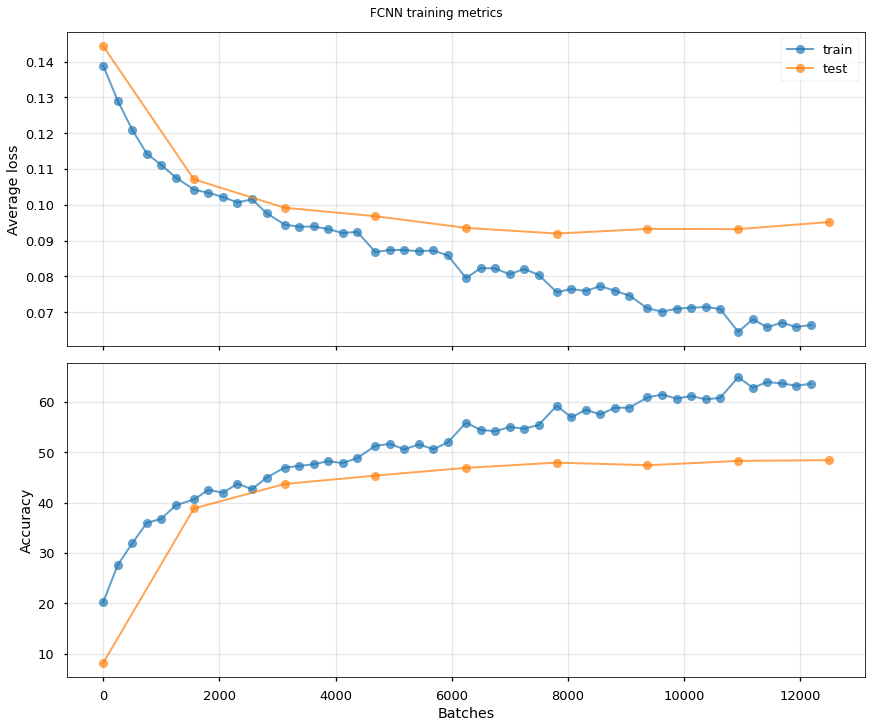

In [22]:
fig = plot_training_metrics(fcnn_metrics)
fig.suptitle("FCNN training metrics")
fig.savefig("figures/plots/fcnn_training_metrics.png", dpi=150, bbox_inches="tight")

## !Exercise!:

Can you reduce the amount of overfitting and/or hopefully improve test performance with any of the following techniques?
* Adding a dropout layer between the hidden layer and output layer
* Increasing the weight decay in the optimizer
* Using a different optimizer / altering the optimizer parameters
* Changing the batch size


# An image-tailored approach - CNN

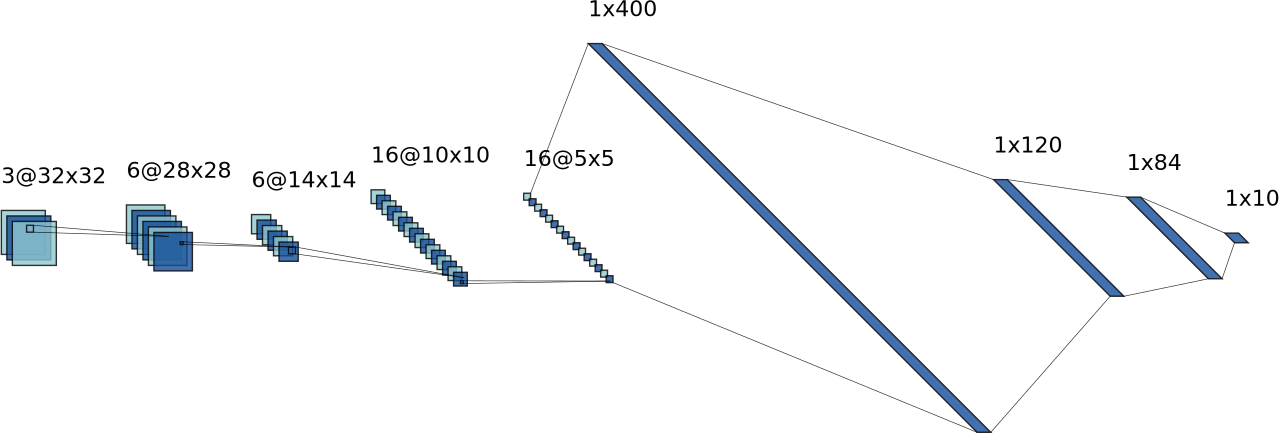

In [23]:
show_svg("figures/networks/cnn.svg")

## Model 

A more suitable approach would be to use a CNN. Here we use a very simple CNN with 2 convolutional layers + max pooling, followed by 3 linear layers.

In [24]:
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=400, out_features=120),
            torch.nn.ReLU(),
#             torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.ReLU(),
        )
        self.classifier = torch.nn.Linear(in_features=84, out_features=10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.features(x)
        logits = self.classifier(features)
        return logits

In [25]:
cnn = ConvolutionalNeuralNetwork().to(DEVICE)
print(cnn)
print(f"Num parameters: {sum(p.numel() for p in cnn.parameters())}")

ConvolutionalNeuralNetwork(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
  )
  (classifier): Linear(in_features=84, out_features=10, bias=True)
)
Num parameters: 62006


Note how many fewer parameters the CNN has than the FCNN

### Thinking in 2D

One important aspect of CNNs is how each of the operations transforms the shape of its input. 

The main two types of operation to be aware of are:
* Convolutions: These can arbitrarily change the number of channels (or *depth*) and, depending on the kernel size, stride and padding, also alter in-plane (x/y) dimensions.
* Pooling: A pooling operation will leave the number of channels unchanged but reduce (often by a factor of 2 or 3) the size of the in-plane (x/y) dimensions.


In [26]:
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
max_pool = torch.nn.MaxPool2d(2, 2)

In [27]:
images, _ = next(iter(train_dataloader))

The shape of the network input is a batch of images with dimensions in the order: 

`batch_size` x `n_image_channels` x `image_height` x `image_width`

The images in CIFAR10 are 32px x 32px RGB (i.e. 3 channel) images 


In [28]:
images.shape

torch.Size([16, 3, 32, 32])

The first convolution goes from the 3 image channels to 6 feature channels and a kernel size of 5x5. Without any padding, this should shave off 2 rows/columns each side of the H/W image dimensions.

In [29]:
conv1(images).shape

torch.Size([16, 6, 28, 28])

 The next operation is a max-pooling operation with a kernel size of 2x2. This should simply reduce the H/W image dimensions by a factor of 2.

In [30]:
max_pool(conv1(images)).shape

torch.Size([16, 6, 14, 14])

The second convolution goes from 6 to 16 feature channels with a kernel size of 5x5. Again, this should reduce the H/W dimensions by 4.

In [31]:
conv2(max_pool(conv1(images))).shape

torch.Size([16, 16, 10, 10])

Max pools will reduce H/W by a factor of 2 again.

In [32]:
max_pool(conv2(max_pool(conv1(images)))).shape

torch.Size([16, 16, 5, 5])

These 16 x 5 x 5 = 400 features are then flattened and used as input to the fully-connected latter part of the network.

## Optimizer

In [33]:
cnn_optimizer = OPTIMIZER_TYPE(
    cnn.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
)
print(cnn_optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## Training

In [34]:
# Repeat model/optimizer initialistion to ensure starting from untrained
# and avoid notebook-cell-execution-order-type errors
cnn = ConvolutionalNeuralNetwork().to(DEVICE)
cnn_optimizer = OPTIMIZER_TYPE(
    cnn.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=WEIGHT_DECAY,
)
# Train the model
cnn_metrics = train_model(
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=cnn,
    optimizer=cnn_optimizer,
    loss_fn=LOSS_FN,
    device=DEVICE,
    n_epochs=N_EPOCHS,
)

2021-06-18 17:53:13.766 | INFO | Testing: ----------------------- | Top-1 Accuracy: 10.5% | Top-3 Accuracy: 30.0% | Average Loss: 0.1440
2021-06-18 17:53:13.770 | INFO | ======================================== Epoch 1 / 8 ========================================
2021-06-18 17:53:15.777 | INFO | Training: Batch 0250/1562 (016%) | Top-1 Accuracy: 10.5% | Top-3 Accuracy: 30.0% | Average Loss: 0.1439
2021-06-18 17:53:17.715 | INFO | Training: Batch 0500/1562 (032%) | Top-1 Accuracy: 09.9% | Top-3 Accuracy: 30.8% | Average Loss: 0.1439
2021-06-18 17:53:19.653 | INFO | Training: Batch 0750/1562 (048%) | Top-1 Accuracy: 11.4% | Top-3 Accuracy: 33.2% | Average Loss: 0.1437
2021-06-18 17:53:21.630 | INFO | Training: Batch 1000/1562 (064%) | Top-1 Accuracy: 14.0% | Top-3 Accuracy: 37.9% | Average Loss: 0.1433
2021-06-18 17:53:23.510 | INFO | Training: Batch 1250/1562 (080%) | Top-1 Accuracy: 16.4% | Top-3 Accuracy: 41.0% | Average Loss: 0.1424
2021-06-18 17:53:25.465 | INFO | Training: Batch 15

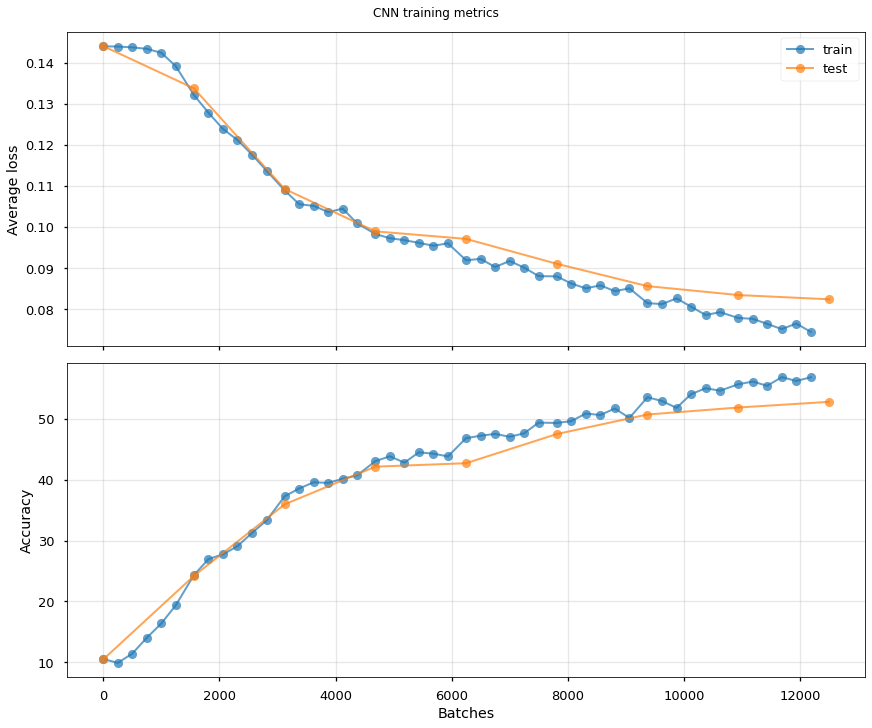

In [35]:
fig = plot_training_metrics(cnn_metrics)
fig.suptitle("CNN training metrics")
fig.savefig("figures/plots/cnn_training_metrics.png", dpi=150, bbox_inches="tight")

## !Exercise!:

Can you reduce the amount of overfitting and/or improve test performance with any of the following techniques?
* Adding a dropout layer between the two linear layers
* Increasing the weight decay in the optimizer
* Using a different optimizer / altering the optimizer parameters
* Changing the batch size
* Adding batch normalisation


# Using a pretrained model

## Model

Pretrained models (often pretrained on the ImageNet dataset) are available from many sources. Here we use torchvision.models. These models have been trained on imagenet which has 1M images and 1000 different classes. This kind of pretraining allows you to leverage the hardware required to train these bigger models on much larger datasets on your own machine.

In [36]:
squeeze_net = tv.models.squeezenet.squeezenet1_1(pretrained=True)
squeeze_net

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

Although his model is pretrained, it is not pretrained for this classification task so we need to make some alterations to make it fit. The model architecture is conveniently divided into `squeezenet.features` which we can leave as they are and `squeezenet.classifier` which currently returns a 1000-way classifaction output (from ImageNet) that we need to swap out for a classifier that will work for CIFAR10.

In [37]:
squeeze_net.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Conv2d(512, 256, kernel_size=1, stride=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.AdaptiveAvgPool2d((1, 1)),
    torch.nn.Flatten(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(128, 10),
)

squeeze_net

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

Given this model was never trained on CIFAR10 plus we've just added a classifer that has untrained weights in it, we would expect the performance to be random

In [38]:
test_epoch(
    test_dataloader, model=squeeze_net.to(DEVICE), loss_fn=LOSS_FN, device=DEVICE
)

2021-06-18 17:55:25.610 | INFO | Testing: ----------------------- | Top-1 Accuracy: 11.2% | Top-3 Accuracy: 31.8% | Average Loss: 0.1562


{'top1accuracy': 11.21,
 'top3accuracy': 31.790000000000003,
 'loss': 0.15618530287742616}

## Optimizer

In [39]:
squeeze_net_optimzer = OPTIMIZER_TYPE(
    squeeze_net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM
)
squeeze_net_optimzer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

## Training (fine-tuning)

Given the increased size of this model, we will use more of the data to limit overfitting and train for more epochs. Feel free to reduce either of these to reduce running time.

In [40]:
train_dataloader_squeezenet = get_cifar10_dataloader(
    is_train=True, 
    augmentations=AUGMENTATIONS, 
    batch_size=32, 
    data_sample_frac=1
)
lr_squeeze_net = 1e-4  # Note the lower learning rate for fine tuning
n_epochs_squeezenet = 16
log_interval_squeezenet = 250

Files already downloaded and verified


In [41]:
# Repeat model/optimizer initialistion to ensure starting from untrained
# and avoid notebook-cell-execution-order-type errors
squeeze_net = tv.models.squeezenet.squeezenet1_1(pretrained=True)
squeeze_net.classifier = torch.nn.Sequential(
    torch.nn.Conv2d(512, 256, kernel_size=1, stride=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.AdaptiveAvgPool2d((1, 1)),
    torch.nn.Flatten(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(128, 10),
)
squeeze_net = squeeze_net.to(DEVICE)

# Freeze some parameters we don't want to optimize
# Here we just freeze the first convolutional layer 
for param_name, param in squeeze_net.features.named_parameters():
    if param_name.startswith("conv.0"):
        param.requires_grad = False

squeeze_net_optimzer = OPTIMIZER_TYPE(
    squeeze_net.parameters(),
    lr=lr_squeeze_net,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
)

# Here we also use a learning rate scheduler to change the learning 
# during the course of training - see here 
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
one_cycle_lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    squeeze_net_optimzer,
    max_lr=lr_squeeze_net * 2,  # Peak learning rate of cycle
    epochs=n_epochs_squeezenet,
    steps_per_epoch=len(train_dataloader_squeezenet),
)

squeezenet_metrics = train_model(
    train_dataloader=train_dataloader_squeezenet,
    test_dataloader=test_dataloader,
    model=squeeze_net,
    loss_fn=LOSS_FN,
    optimizer=squeeze_net_optimzer,
    device=DEVICE,
    n_epochs=n_epochs_squeezenet,
    lr_scheduler=one_cycle_lr_scheduler,
    log_interval=log_interval_squeezenet
)

2021-06-18 17:55:32.718 | INFO | Testing: ----------------------- | Top-1 Accuracy: 09.8% | Top-3 Accuracy: 28.5% | Average Loss: 0.1652
2021-06-18 17:55:32.721 | INFO | ======================================= Epoch 1 / 16 ========================================
2021-06-18 17:55:39.165 | INFO | Training: Batch 0250/1562 (016%) | Top-1 Accuracy: 14.1% | Top-3 Accuracy: 37.6% | Average Loss: 0.1452 | lr: 0.00001
2021-06-18 17:55:45.574 | INFO | Training: Batch 0500/1562 (032%) | Top-1 Accuracy: 26.6% | Top-3 Accuracy: 55.8% | Average Loss: 0.1290 | lr: 0.00001
2021-06-18 17:55:52.049 | INFO | Training: Batch 0750/1562 (048%) | Top-1 Accuracy: 33.3% | Top-3 Accuracy: 66.5% | Average Loss: 0.1165 | lr: 0.00001
2021-06-18 17:55:58.342 | INFO | Training: Batch 1000/1562 (064%) | Top-1 Accuracy: 40.8% | Top-3 Accuracy: 73.5% | Average Loss: 0.1040 | lr: 0.00002
2021-06-18 17:56:04.808 | INFO | Training: Batch 1250/1562 (080%) | Top-1 Accuracy: 44.2% | Top-3 Accuracy: 77.4% | Average Loss: 0.

## Results

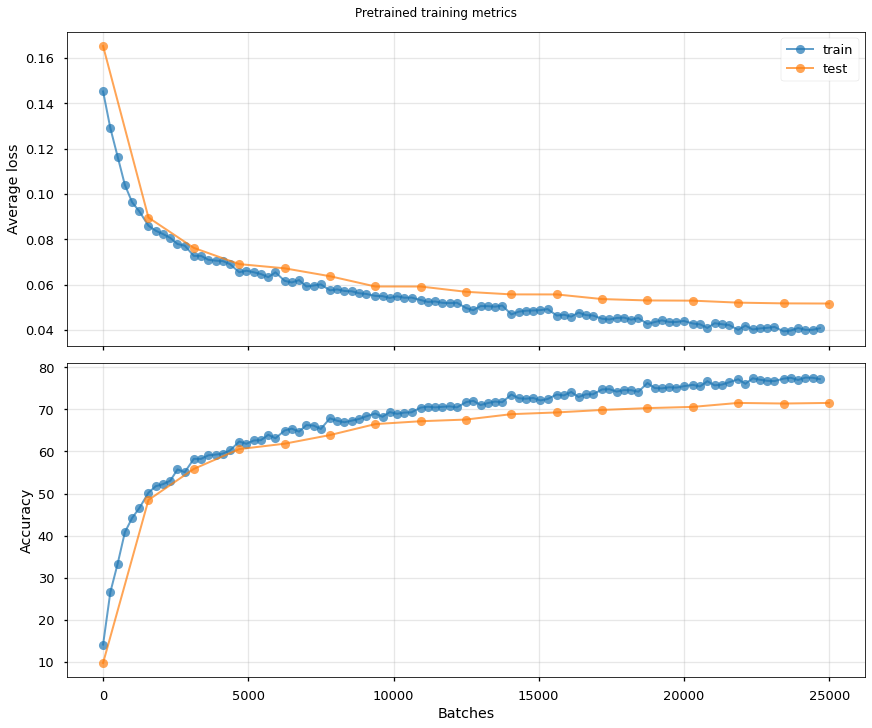

In [42]:
fig = plot_training_metrics(squeezenet_metrics)
fig.suptitle("Pretrained training metrics")
fig.savefig(
    "figures/plots/pretrained_training_metrics.png", dpi=150, bbox_inches="tight"
)

## !Exercise!

Can you reduce the amount of overfitting and/or hopefully improve test performance with any of the following techniques?
* Changing which layers are frozen in the pretrained netowrk
* Chaning the architecture of the new classifier we added
* Any of the previous techniques


# Saving/Loading models

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [43]:
torch.save(squeeze_net.state_dict(), "squeeze_net_tuned.pth")
print("Saved PyTorch Model State to squeeze_net_tuned.pth")

Saved PyTorch Model State to squeeze_net_tuned.pth


The process for loading a model is to re-create the model structure and load
the state dictionary into it.

In [44]:
squeeze_net_loaded = tv.models.squeezenet.squeezenet1_1(pretrained=False)
squeeze_net_loaded.classifier = torch.nn.Sequential(
    torch.nn.Conv2d(512, 256, kernel_size=1, stride=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.AdaptiveAvgPool2d((1, 1)),
    torch.nn.Flatten(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(128, 10),
)
squeeze_net_loaded.load_state_dict(torch.load("squeeze_net_tuned.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



In [45]:
example_idx = 205

squeeze_net_loaded.eval()
x, y = test_data[example_idx]
with torch.no_grad():
    pred = squeeze_net_loaded(torch.unsqueeze(x, dim=0))
    predicted, actual = CLASSES[pred[0].argmax(0)], CLASSES[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "cat", Actual: "cat"


# Analysis

To get the model scores and features on the test set we process the whole test_dataset with a batch_size of 1 and then construct a dataframe from these results.

In [46]:
def evaluate_model(
    dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    device: torch.device,
) -> pd.DataFrame:
    assert dataloader.batch_size == 1
    data = collections.defaultdict(list)
    model.eval()
    with torch.no_grad():
        for image, label in tqdm.tqdm(dataloader):
            image, label = image.to(device), label.to(device)
            logit_scores = model(image)
            features = model.to(device).features(image)
            loss = loss_fn(logit_scores, label).item()
            softmax_scores = torch.nn.functional.softmax(logit_scores, dim=1).squeeze()
            pred_label = softmax_scores.argmax(dim=0)
            data["loss"].append(loss)
            data["pred_label"].append(pred_label.item())
            data["label"].append(label.item())
            for feauture_idx, feature in enumerate(features.squeeze()):
                data[f"feature{feauture_idx}"].append(feature.item())
            for class_idx, softmax_score in enumerate(softmax_scores):
                data[f"score{class_idx}"].append(softmax_score.item())
    return pd.DataFrame.from_dict(data)

In [47]:
test_dataloader_bs1 = get_cifar10_dataloader(
    is_train=False, 
    augmentations=AUGMENTATIONS, 
    batch_size=1, # Batch size of 1 (to get loss per sample)
    data_sample_frac=1
)
df = evaluate_model(test_dataloader_bs1, squeeze_net, LOSS_FN, DEVICE)  # Takes about 2 mins for squeezenet for data_sample_frac=1

Files already downloaded and verified


100%|██████████| 10000/10000 [03:13<00:00, 51.70it/s]


In [48]:
df.head()

,loss,pred_label,label,feature0,feature1,feature2,feature3,feature4,feature5,feature6,...,score0,score1,score2,score3,score4,score5,score6,score7,score8,score9
0,0.641133,5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000304,0.000068,0.013039,0.239496,0.025129,0.526696,0.187532,0.000860,0.006770,0.000106
1,0.747710,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013912,0.473449,0.000079,0.000676,0.000015,0.000024,0.000091,0.000097,0.407557,0.104098
2,1.320171,8,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012810,0.000561,0.031526,0.267090,0.013436,0.009183,0.019468,0.023429,0.621761,0.000734
3,0.009698,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.990349,0.004151,0.001658,0.000189,0.000271,0.000036,0.000027,0.000327,0.000619,0.002373
4,0.013464,6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000163,0.000165,0.003181,0.008443,0.000132,0.000595,0.986626,0.000026,0.000356,0.000313


Overall top-1 accuracy on test set

In [49]:
scores = df.loc[:, "score0":"score9"]
sklearn.metrics.top_k_accuracy_score(df.label, scores, k=1)

0.7154

Overall top-3 accuracy on test set

In [50]:
scores = df.loc[:, "score0":"score9"]
sklearn.metrics.top_k_accuracy_score(df.label, scores, k=3)

0.9313

## Visualise examples 

**Random 10**

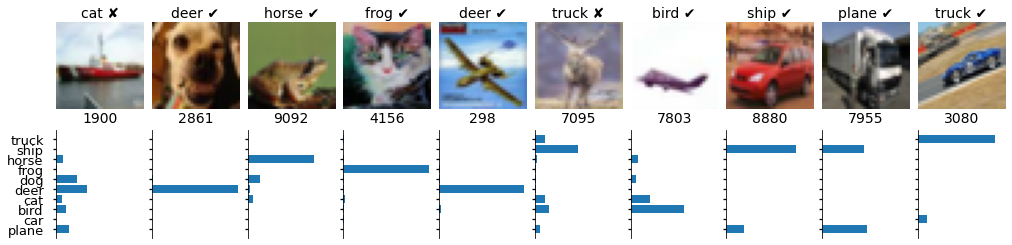

In [51]:
df_10_random = df.sample(10)
fig = display_prediction_images(df_10_random)

**10 examples with the highest loss**

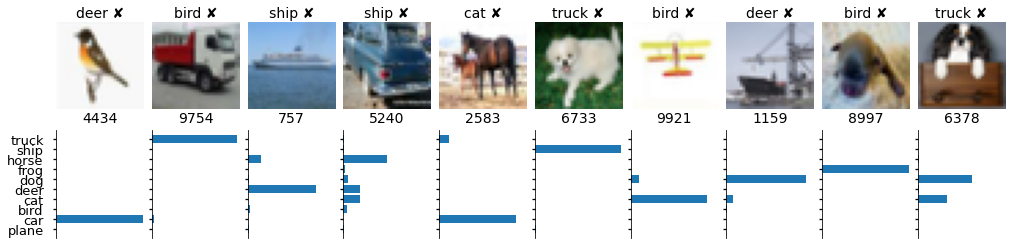

In [52]:
df_10_highest_loss = df.sort_values(by="loss", ascending=False)[:10]
fig = display_prediction_images(df_10_highest_loss)

**10 examples with the lowest loss**

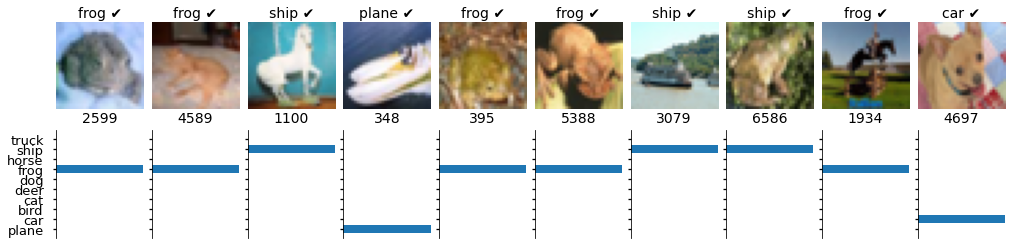

In [53]:
df_10_lowest_loss = df.sort_values(by="loss", ascending=True)[:10]
fig = display_prediction_images(df_10_lowest_loss)

## Visualise model feature distribution

In [54]:
# Hyperparameters
PERPLEXITY = 30
TSNE_ITERS = 1000
TSNE_LR = 300


pca = sklearn.decomposition.PCA(n_components=30)
tsne = sklearn.manifold.TSNE(
    perplexity=PERPLEXITY, n_iter=TSNE_ITERS, learning_rate=TSNE_LR, verbose=True
)
features = df.loc[:, "feature0":"feature511"]
pca_features = pca.fit_transform(features)
tsne_coords = tsne.fit_transform(pca_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 2.614s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 49.116854
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.397705
[t-SNE] KL divergence after 1000 iterations: 2.407999


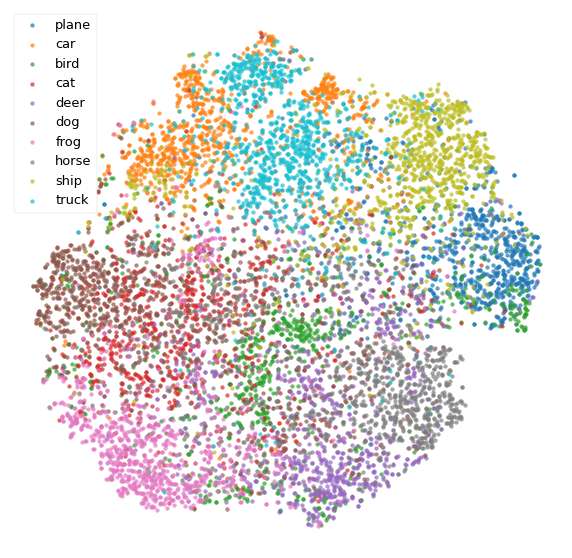

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
for label, group_df in df.groupby("label"):
    ax.scatter(*tsne_coords[group_df.index].T, s=14, label=CLASSES[label], alpha=0.7)
ax.legend()
ax.axis("off")
fig.savefig("figures/plots/pretrained_tsne.png", dpi=150, bbox_inches="tight")

# Further exercises

## Training augmentation

Data augmentation is ubiquitous technique in computer vision. It allows you to 'increase' the size of your dataset by generating many training examples per actual example and increases robustness to expected changes in the format of the input data. By adding the variation to the input data, augmentation also has a regularising effect.

Try retrainining the CNN using the following augmentations in the training data loader: (you have have to train for more epochs to reach a reasonable performance)

In [56]:
train_augmentations = tv.transforms.Compose(
    [
        tv.transforms.RandomVerticalFlip(),
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.RandomResizedCrop(size=32, scale=(0.8, 1)),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataloader_augment = get_cifar10_dataloader(
    is_train=True, 
    batch_size=BATCH_SIZE, 
    augmentations=train_augmentations, 
    data_sample_frac=TRAIN_DATA_SAMPLE_FRAC,
)

Files already downloaded and verified


Try adding to/changing the augmentations (there are many more options in torchvision.transforms). Just be sure to only use augmentations that leave the dimenions of the input data unchanged or the network will not be able to process it.

## Test-time Augmentation

Doing augmentation at test/inference-time may seem like an odd thing to do as it may obfuscate the image you are doing your best to predict the class of. However, test-time augmentation can be used to improve performance in a similar way to ensembling. You can roughly consider the model run with each augmentation of an image as a separate member of an 'ensemble' of models and take the mean score across all augmentations.

NOTE: You must use a model that has seen these augmentations before (i.e. the model we just trained above), otherwise the shift in data distribution from perfect unchanged images to augmented ones will result in a poor model performance.

Try running the model evaluation multiple with the following augmentations. You can then take the mean across all the evaluations for each image to get the final score. 

How does this impact performance? How does this vary as a function of test-time augmentations?

In [57]:
test_augmentations = tv.transforms.Compose(
    [
        tv.transforms.RandomVerticalFlip(),
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.RandomResizedCrop(size=32, scale=(0.8, 1)),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


test_dataloader_bs1_augment = get_cifar10_dataloader(
    is_train=False, 
    batch_size=1, 
    augmentations=test_augmentations, 
    data_sample_frac=0.2
)

Files already downloaded and verified


## Ensembling

Another popular technique to improve prediction performance is to train an ensemble of models and combine their predictions. Although there are many ways to create different models to ensemble, the easiest (but still very effective) method is just to repeat the training process multiple times. Optimization of neural networks is non-deterministic by nature so simply creating multiple model instances (each with a corresponding optimzer) and training each one gives you a good ensemble.

Try training another few CNNs, running the evaluation on each and combining the scores (simply by taking the mean over the ensemble). How much does performance improve by? How does this vary by number of models in the ensemble?